In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy import units as un
from scipy import constants as cs
from scipy import optimize as opt
from scipy import integrate as intg
import galpy.potential as pot
from galpy.orbit import Orbit
from galpy.util import bovy_coords
from galpy.actionAngle import actionAngleIsochrone
%matplotlib inline

In [2]:
# Daten einlesen
if 1:
    r_3d,m1,m2,x,y,z,vx,vy,vz,vr,vtheta,vphi=np.loadtxt('C:\\Users\Sophia Milanov\Documents\Bachelorarbeit\data\\x-y-z.dat', usecols=(1,9,10,30,31,32,33,34,35,36,37,38), unpack=True)
else:
    r_3d,m1,m2,x,y,z,vx,vy,vz,vr,vtheta,vphi=np.loadtxt('/home/milanov/Bachelorarbeit/x-y-z.dat', usecols=(1,9,10,30,31,32,33,34,35,36,37,38), unpack=True)

In [3]:
mges=un.solMass.to(un.kg,np.sum(m1+m2))

ni=75946

xi=x[ni]
yi=y[ni]
zi=z[ni]

vxi=vx[ni]
vyi=vy[ni]
vzi=vz[ni]

xim=un.pc.to(un.m, xi)
yim=un.pc.to(un.m, yi)
zim=un.pc.to(un.m, zi)

x0=xim
y0=yim
z0=zim

kms=un.km/un.s
ms=un.m/un.s

r=np.sqrt(x**2+y**2+z**2)
ri=r[ni]
rim=un.pc.to(un.m,ri)

vxim=kms.to(ms,vxi)
vyim=kms.to(ms,vyi)
vzim=kms.to(ms,vzi)

vx0=vxim
vy0=vyim
vz0=vzim


N=200000
start=0
end=1e14
t=np.linspace(start,end,N)
dt=t[1]-t[0]

vri=vr[ni]
vrim=kms.to(ms,vri)

In [4]:
# some potential
b=10.
phi=-cs.G*mges/(b+np.sqrt(b**2+rim**2))
phi_dyn=-cs.G/(b+np.sqrt(b**2+rim**2))

def force_isochrone(x,y,z):

    r=np.sqrt(x**2+y**2+z**2)
#    phi=-cs.G*mges/(b+np.sqrt(b**2+r**2))
    a=np.zeros(3)
    a[0]=-cs.G*mges*x/(np.sqrt(b**2+r**2)*(np.sqrt(b**2+r**2)+b)**2)
    a[1]=-cs.G*mges*y/(np.sqrt(b**2+r**2)*(np.sqrt(b**2+r**2)+b)**2)
    a[2]=-cs.G*mges*z/(np.sqrt(b**2+r**2)*(np.sqrt(b**2+r**2)+b)**2)
    return a


leapfrog:

$x_{i+1}=x_i+v_i\Delta t+\frac{a_i(x_i)}{2}\Delta t^2$

$v_{i+1}=v_i+\frac{a(x_{i+1})+a(x_i)}{2}\Delta t$

In [5]:
#leapfrog
xl=np.zeros(N+1)
yl=np.zeros(N+1)
zl=np.zeros(N+1)

x_l=np.sqrt(xl**2+yl**2+zl**2)

vxl=np.zeros(N+1)
vyl=np.zeros(N+1)
vzl=np.zeros(N+1)

xl[0]=x0
yl[0]=y0
zl[0]=z0

vxl[0]=vx0
vyl[0]=vy0
vzl[0]=vz0

for i in range(N):
    xl[0]=x0
    yl[0]=y0
    zl[0]=z0
    
    a=force_isochrone(xl[i],yl[i],zl[i])
    
    xl[i+1]=xl[i]+vxl[i]*dt+1./2.*a[0]*dt**2
    yl[i+1]=yl[i]+vyl[i]*dt+1./2.*a[1]*dt**2
    zl[i+1]=zl[i]+vzl[i]*dt+1./2.*a[2]*dt**2
    
    a_1=force_isochrone(xl[i+1],yl[i+1],zl[i+1])
    
    vxl[i+1]=vxl[i]+1./2.*(a[0]+a_1[0])*dt
    vyl[i+1]=vyl[i]+1./2.*(a[1]+a_1[1])*dt
    vzl[i+1]=vzl[i]+1./2.*(a[2]+a_1[2])*dt


In [6]:
#galpy crosscheck
isopot=pot.IsochronePotential(amp=cs.G*mges,b=b,normalize=False)

#in Galactocentric cylindrical coordinates vxvv=[R,vR,vT(,z,vz,phi)]
R,phi,z_new=bovy_coords.rect_to_cyl(xim,yim,zim) #ort
vR,vT,vz_new=bovy_coords.rect_to_cyl_vec(vxim,vyim,vzim,xim,yim,zim) #geschw
o=Orbit(vxvv=[R,vR,vT,z_new,vz_new,phi])
o.integrate(t,isopot)


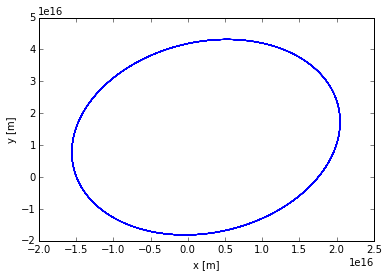

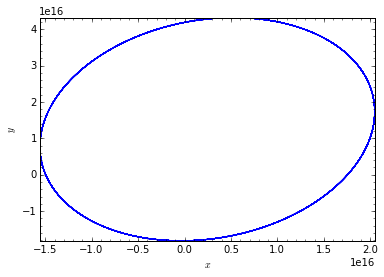

In [7]:
xlpc=un.m.to(un.pc,xl)
ylpc=un.m.to(un.pc,yl)
zlpc=un.m.to(un.pc,zl)
plt.plot(xl,yl)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
o.plot(d1='x',d2='y')

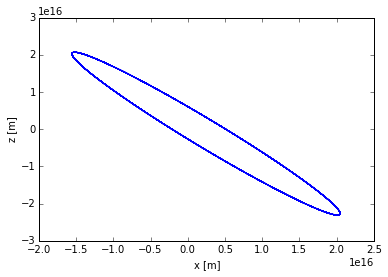

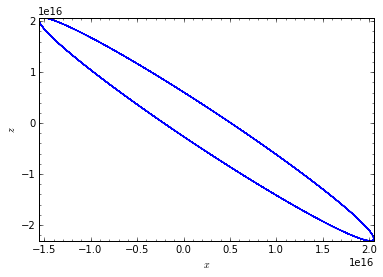

In [8]:
plt.plot(xl,zl)
plt.xlabel('x [m]')
plt.ylabel('z [m]')
o.plot(d1='x',d2='z')

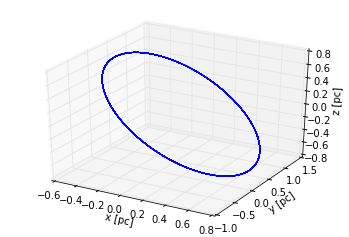

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xlpc,ylpc,zlpc)
ax.set_xlabel('x [pc]')
ax.set_ylabel('y [pc]')
ax.set_zlabel('z [pc]')

actions
---

In [10]:
#angular moments without mass
Lx=yl*vzl-zl*vyl
Ly=zl*vxl-xl*vzl
Lz=xl*vyl-yl*vxl

L=np.sqrt(Lx**2+Ly**2+Lz**2)

#phi=-cs.G*mges/(b+np.sqrt(b**2+rim**2))
phipot=-cs.G*mges/(b+np.sqrt(b**2+(np.sqrt(xl**2+yl**2+zl**2))**2))

E=vxl**2./2.+vyl**2./2.+vzl**2./2.+phipot

rl=np.sqrt(xl**2+yl**2+zl**2)

def Phi(r):
    return -cs.G*mges/(b+np.sqrt(b**2+r**2))

def periapocenter(r,pot):
    pot=Phi(r)
    return (1/r)**2.+2.*(pot-E[0])/L[0]**2.

rmin=opt.fsolve(periapocenter,np.min(rl),Phi(np.min(rl)))
rmax=opt.fsolve(periapocenter,np.max(rl),Phi(np.max(rl)))

def jrint(r,pot):
    pot=Phi(r)
    return np.sqrt(2.*E[0]-2.*pot-L[0]**2./r**2.)

J_phi=Lz
J_theta=L-np.abs(Lz)

J_r=np.zeros(len(J_phi))
for i in range(len(J_r)):
    J_r[i]=1/np.pi*intg.quad(jrint,rmin,rmax,args=(Phi(rl[i])))[0]
#J_ri=cs.G*mges/np.sqrt(-2.*E)-1./2.*(L+np.sqrt(L**2.-4.*cs.G*mges*b))

print(rmin,rmax)

(array([  1.80901751e+16]), array([  4.36830715e+16]))


In [11]:
aAI= actionAngleIsochrone(ip=isopot)

In [12]:
#galpy
tJ=np.linspace(start,end,N+1)
tg=np.linspace(start,end,N/100)
jfa= aAI.actionsFreqs(o.R(tg),o.vR(tg),o.vT(tg),o.z(tg),o.vz(tg),o.phi(tg))

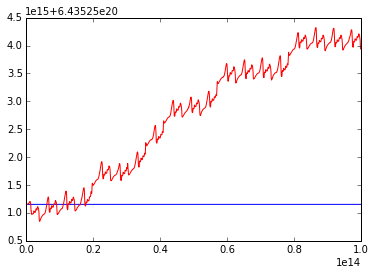

In [13]:
plt.plot(tJ,J_phi,'b',tg,jfa[1],'r')

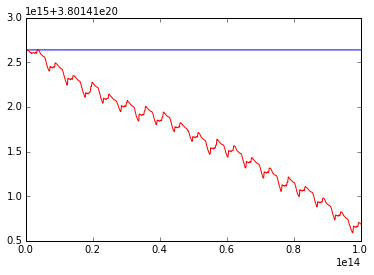

In [14]:
plt.plot(tJ,J_theta,'b',tg,jfa[2],'r')

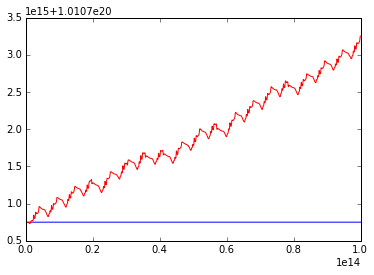

In [15]:
plt.plot(tJ,J_r,'b',tg,jfa[0],'r')


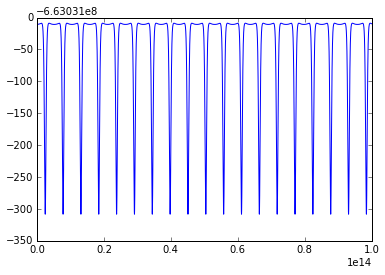

In [16]:
plt.plot(tJ,E)